In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import json
import re


In [4]:
## Buscar todos los .log dentro de benchmark/logs_bench y subcarpetas
log_files = glob.glob("../benchmark/logs_bench/**/*.log", recursive=True)

print("Archivos encontrados:", log_files[:5])  # muestra solo los primeros
print("Total de archivos:", len(log_files))


Archivos encontrados: ['../benchmark/logs_bench/bench_worker1/endpoints.log', '../benchmark/logs_bench/bench_worker1/function_state.log', '../benchmark/logs_bench/bench_worker1/function_result.log', '../benchmark/logs_bench/bench_worker1/endpoint_state.log', '../benchmark/logs_bench/bench_worker1/security_policy.log']
Total de archivos: 27


In [5]:
records = []

for file in log_files:
    buffer = ""  # para JSON multilínea
    with open(file) as f:
        for line in f:
            line = line.strip()
            if not line:
                continue

            buffer += line
            if line.endswith("}"):  # asumimos que aquí termina un JSON
                try:
                    data = json.loads(buffer)
                    if "event" in data:  # solo logs válidos
                        data["worker"] = int(re.findall(r"worker(\d+)", file)[0])
                        records.append(data)
                except Exception as e:
                    print(f"⚠️ Error parseando en {file}: {e}")
                buffer = ""  # reiniciar buffer

df = pd.DataFrame(records)

print("Columnas disponibles:", df.columns.tolist())
df.head()



Columnas disponibles: ['event', 'path', 'status', 'elapsed', 'logger_name', 'worker']


,event,path,status,elapsed,logger_name,worker
0,POST.ENDPOINT,/api/v1/endpoints/,200,0.210,endpoints_worker1,1
1,POST.ENDPOINT,/api/v1/endpoints/,200,0.340,endpoints_worker1,1
2,POST.ENDPOINT,/api/v1/endpoints/,200,0.350,endpoints_worker1,1
3,POST.ENDPOINT,/api/v1/endpoints/,200,0.232,endpoints_worker1,1
4,POST.ENDPOINT,/api/v1/endpoints/,200,0.315,endpoints_worker1,1


In [6]:
# Separar operación y entidad (ejemplo: CREATE.ENDPOINT → CREATE, ENDPOINT)
df[['Operación', 'Entidad']] = df['event'].str.split('.', expand=True, n=1)

# Asegurar tipos correctos
df['elapsed'] = df['elapsed'].astype(float)
df['worker'] = df['worker'].astype(int)

df.head()



,event,path,status,elapsed,logger_name,worker,Operación,Entidad
0,POST.ENDPOINT,/api/v1/endpoints/,200,0.210,endpoints_worker1,1,POST,ENDPOINT
1,POST.ENDPOINT,/api/v1/endpoints/,200,0.340,endpoints_worker1,1,POST,ENDPOINT
2,POST.ENDPOINT,/api/v1/endpoints/,200,0.350,endpoints_worker1,1,POST,ENDPOINT
3,POST.ENDPOINT,/api/v1/endpoints/,200,0.232,endpoints_worker1,1,POST,ENDPOINT
4,POST.ENDPOINT,/api/v1/endpoints/,200,0.315,endpoints_worker1,1,POST,ENDPOINT


In [7]:
metrics = df.groupby(['Entidad', 'Operación', 'worker']).agg(
    avg_time=('elapsed', 'mean'),
    min_time=('elapsed', 'min'),
    max_time=('elapsed', 'max'),
    std_time=('elapsed', 'std'),
    success_rate=('status', lambda x: (x == 200).mean())
).reset_index()

metrics



,Entidad,Operación,worker,avg_time,min_time,max_time,std_time,success_rate
0,ENDPOINT,DELETE,1,0.172101,0.035,0.454,0.084521,1.0
1,ENDPOINT,DELETE,2,0.154714,0.031,0.426,0.076440,1.0
2,ENDPOINT,DELETE,4,0.241438,0.045,0.582,0.117426,1.0
3,ENDPOINT,GET,1,0.163009,0.033,0.411,0.077554,1.0
4,ENDPOINT,GET,2,0.150396,0.027,0.537,0.075801,1.0
...,...,...,...,...,...,...,...,...
103,SERVICE,POST,2,0.157868,0.033,0.436,0.075373,1.0
104,SERVICE,POST,4,0.249045,0.047,0.616,0.120234,1.0
105,SERVICE,PUT,1,0.212005,0.043,0.539,0.094555,1.0
106,SERVICE,PUT,2,0.178755,0.040,0.466,0.077943,1.0


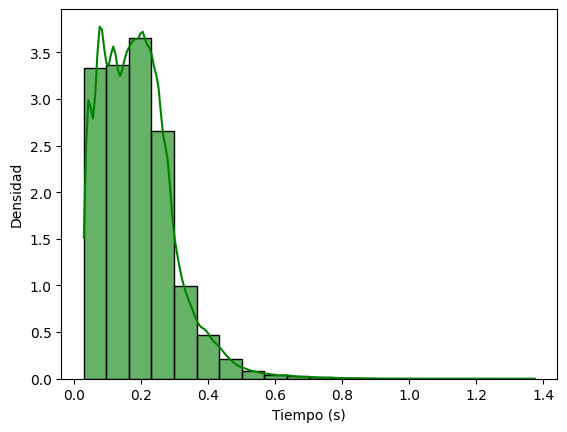

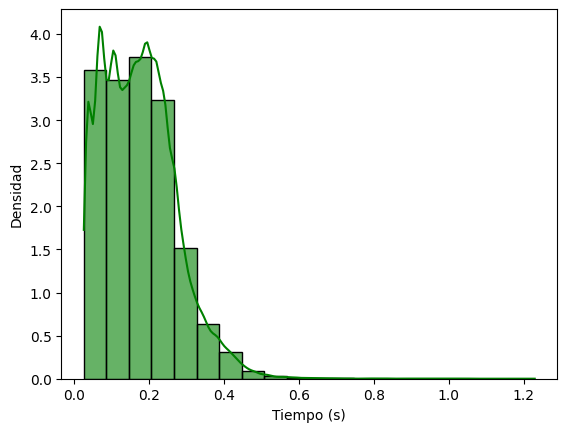

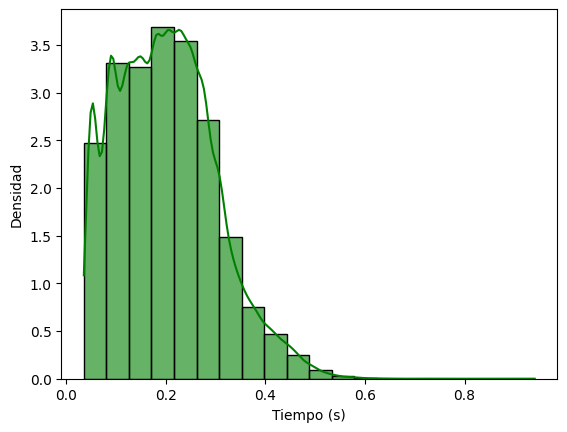

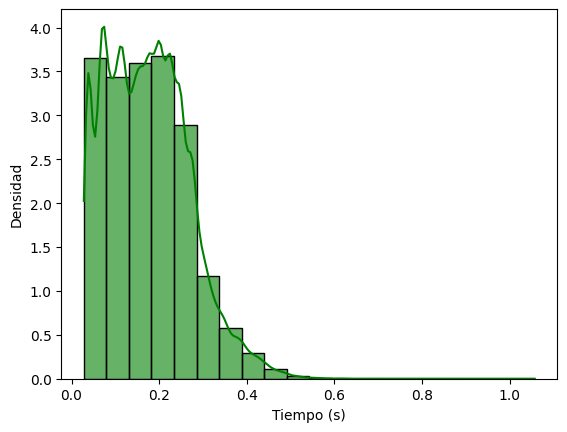

In [9]:
for op in df['Operación'].unique():
    subset = df[df['Operación'] == op]

    sns.histplot(
        subset['elapsed'],
        bins=20,
        kde=True,
        stat="density",
        alpha=0.6,
        color="green", 
    
    )
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Densidad")

    # Guardar en PNG y PDF
    plt.savefig(f"histograma_{op}.png", dpi=300, bbox_inches ="tight")
    plt.savefig(f"histograma_{op}.pdf", bbox_inches="tight")



    plt.show()
    plt.close()



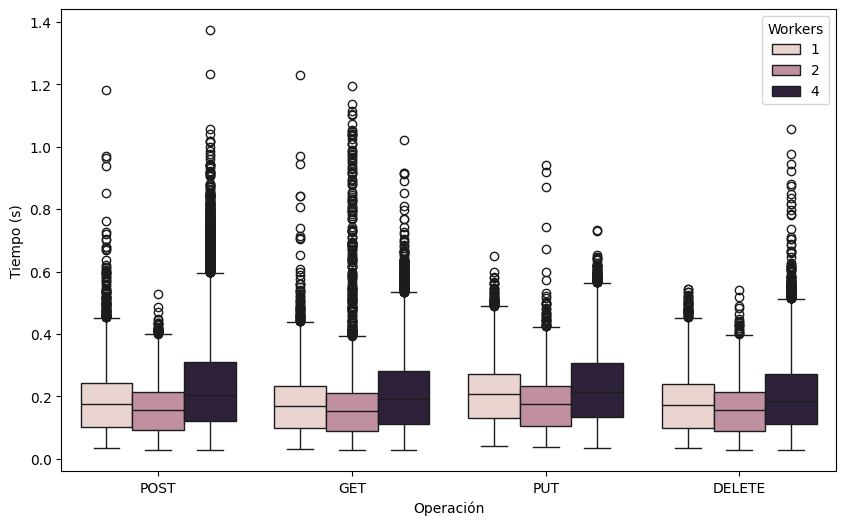

In [10]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='Operación', y='elapsed', hue='worker')
plt.ylabel("Tiempo (s)")
plt.xlabel("Operación")
plt.legend(title="Workers")

plt.savefig("comparacion_operaciones.pdf", format="pdf", bbox_inches="tight")
plt.savefig("comparacion_operaciones.png", format="png", dpi=300, bbox_inches="tight")
plt.show()



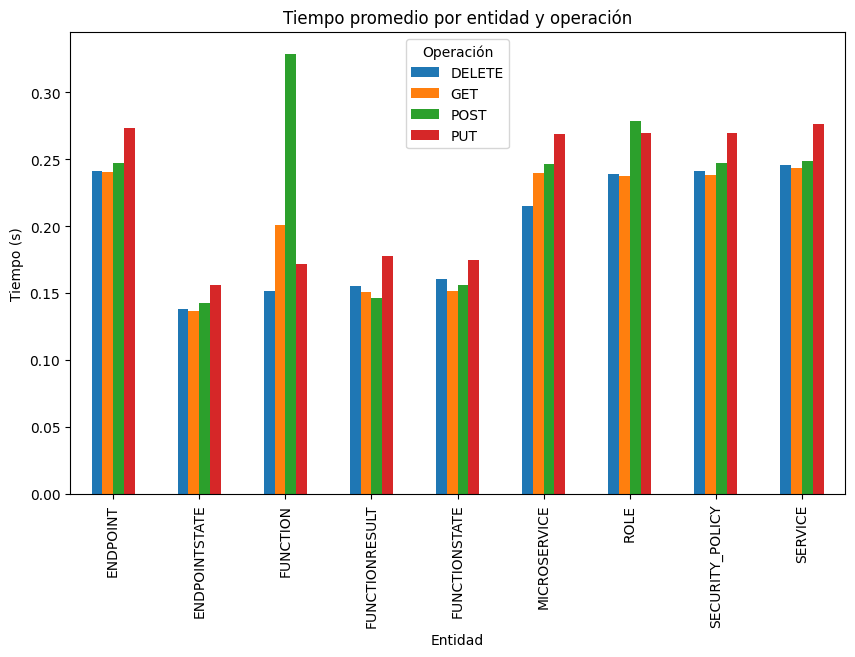

In [28]:
avg_entity = df.groupby(['Entidad', 'Operación'])['elapsed'].mean().unstack()
avg_entity.plot(kind='bar', figsize=(10,6))
plt.title("Tiempo promedio por entidad y operación")
plt.ylabel("Tiempo (s)")
plt.show()

